# Document Classifier Evaluation

In [11]:
import os
import sys
from pathlib import Path
from collections import Counter, defaultdict
import pandas as pd

current_dir = Path(os.getcwd())

project_root = current_dir
while not (project_root / "src").exists() and project_root.parent != project_root:
    project_root = project_root.parent

project_root = str(project_root)
src_root = os.path.join(project_root, "src")

# Add to system path
if project_root not in sys.path:
    sys.path.insert(0, project_root)
if src_root not in sys.path:
    sys.path.insert(0, src_root)

print(f"✅ Project Root set to: {project_root}")

from src.utils.document_classification import (
    load_files, extract_text, clean_texts, 
    load_tfidf_model, load_tfidf_vectorizer, classify_document_types
)

CLASSES = {"press_release", "earnings_call", "sec_filing", "news_article", "research_paper"}

✅ Project Root set to: /home/jbatbayar/market-foundry


In [12]:
def normalize_label(s: str) -> str:
    return s.strip().lower()

def canonical_pred(label: str) -> str:
    """Maps both folder names and model output strings to standard snake_case."""
    l = normalize_label(label)
    if l in {"sec_filing", "sec filing", "sec filing"}: return "sec_filing"
    if l in {"press_release", "press release"}: return "press_release"
    if l in {"earnings_call", "earnings call", "earnings_call_transcript", "earnings call transcript"}: return "earnings_call"
    if l in {"news_article", "news article", "news", "article"}: return "news_article"
    if l in {"research_paper", "research paper", "research", "paper"}: return "research_paper"
    return "other"

In [13]:
def run_evaluation():
    eval_root = Path(project_root) / "Papers" / "eval" 
    
    if not eval_root.exists():
        raise FileNotFoundError(f"Eval folder not found: {eval_root.resolve()}")

    file_paths = []
    for cls in CLASSES:
        cls_dir = eval_root / cls
        if cls_dir.exists():
            file_paths.extend([str(p) for p in cls_dir.rglob("*") if p.is_file()])

    if not file_paths:
        raise ValueError("No eval files found under Papers/eval/<class_name>/")

    print(f"🔍 Found {len(file_paths)} files for evaluation. Starting batch processing...")

    loaded_files = load_files(file_paths)
    texts = extract_text(loaded_files)
    cleaned_texts = clean_texts(texts)

    model_path = os.path.join(src_root, "models", "Document_Classifier.joblib")
    vectorizer_path = os.path.join(src_root, "models", "TFIDF_Vectorizer.joblib")
    
    model = load_tfidf_model(model_path)
    vectorizer = load_tfidf_vectorizer(vectorizer_path)

    print("🧠 Classifying documents...")
    classifications = classify_document_types(model, vectorizer, cleaned_texts)

    y_true = []
    y_pred = []
    per_class_counts = Counter()
    confusion = defaultdict(Counter)

    for source_path, pred_str in classifications.items():
        true_label = canonical_pred(Path(source_path).parent.name)
        pred_label = canonical_pred(pred_str)

        if true_label not in CLASSES:
            continue

        y_true.append(true_label)
        y_pred.append(pred_label)

        per_class_counts[true_label] += 1
        confusion[true_label][pred_label] += 1

    correct = sum(t == p for t, p in zip(y_true, y_pred))
    total = len(y_true)
    acc = correct / total if total else 0.0

    metrics = {}
    for cls in sorted(CLASSES):
        tp = sum((t == cls and p == cls) for t, p in zip(y_true, y_pred))
        fp = sum((t != cls and p == cls) for t, p in zip(y_true, y_pred))
        fn = sum((t == cls and p != cls) for t, p in zip(y_true, y_pred))

        precision = tp / (tp + fp) if (tp + fp) else 0.0
        recall = tp / (tp + fn) if (tp + fn) else 0.0
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) else 0.0

        metrics[cls] = {"Precision": precision, "Recall": recall, "F1": f1, "Support": per_class_counts[cls]}

    macro_f1 = sum(m["F1"] for m in metrics.values()) / len(CLASSES)
    weighted_f1 = sum(m["Support"] * m["F1"] for m in metrics.values()) / total if total else 1

    return {
        "total": total,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1,
        "class_metrics": metrics,
        "confusion_matrix": confusion,
        "raw_predictions": classifications
    }

## Run evaluation on eval set

In [14]:
results = run_evaluation()

print(f"Overall Accuracy:  {results['accuracy']:.3f}")
print(f"Macro F1 Score:    {results['macro_f1']:.3f}")
print(f"Weighted F1 Score: {results['weighted_f1']:.3f}\n")

df_metrics = pd.DataFrame(results['class_metrics']).T
display(df_metrics.round(3))

ordered_classes = sorted(CLASSES)
df_confusion = pd.DataFrame(results['confusion_matrix']).T
df_confusion = df_confusion.reindex(index=ordered_classes, columns=ordered_classes).fillna(0).astype(int)

df_confusion.index.name = 'True'
df_confusion.columns.name = 'Predicted'

display(df_confusion)

🔍 Found 85 files for evaluation. Starting batch processing...
Loaded 85 files in 138.47 seconds.
🧠 Classifying documents...
⚡ Loaded 74 reference docs from cache.
Disagreement in classification for RealFin.pdf → Resolved to Research Paper
Disagreement in classification for Personal_Finance_Application.pdf → Resolved to SEC Filing
Disagreement in classification for Financial Statement Analysis with Large Language Models.pdf → Resolved to Research Paper
Disagreement in classification for Financial Statement Analysis with Large Language Models-checkpoint.pdf → Resolved to Research Paper
Disagreement in classification for are-we-in-an-economic-doom-loop.html → Resolved to News Article
Disagreement in classification for anthropic-claude-380b-valuation-openai-rivalry-ipo.html → Resolved to News Article
Disagreement in classification for ubs-lifts-forecast-big-tech-bond-sales-this-year.html → Resolved to News Article
Disagreement in classification for sony-japan-entertainment-electronics-game

,Precision,Recall,F1,Support
earnings_call,1.000,0.923,0.960,13.0
news_article,0.500,1.000,0.667,12.0
press_release,1.000,0.250,0.400,20.0
research_paper,1.000,0.857,0.923,7.0
sec_filing,0.792,1.000,0.884,19.0


Predicted,earnings_call,news_article,press_release,research_paper,sec_filing
True,,,,,
earnings_call,12,0,0,0,1
news_article,0,12,0,0,0
press_release,0,12,5,0,3
research_paper,0,0,0,6,1
sec_filing,0,0,0,0,19


In [15]:
print(df_metrics.round(3))

                Precision  Recall     F1  Support
earnings_call       1.000   0.923  0.960     13.0
news_article        0.500   1.000  0.667     12.0
press_release       1.000   0.250  0.400     20.0
research_paper      1.000   0.857  0.923      7.0
sec_filing          0.792   1.000  0.884     19.0


In [16]:
print(df_confusion)

Predicted       earnings_call  news_article  press_release  research_paper  \
True                                                                         
earnings_call              12             0              0               0   
news_article                0            12              0               0   
press_release               0            12              5               0   
research_paper              0             0              0               6   
sec_filing                  0             0              0               0   

Predicted       sec_filing  
True                        
earnings_call            1  
news_article             0  
press_release            3  
research_paper           1  
sec_filing              19  


In [17]:
def analyze_misclassifications(results_dict, target_true_class="press_release", target_pred_class="news_article"):
#prints the file paths of documents that were misclassified.
    
    raw_preds = results_dict.get("raw_predictions", {})
    
    if not raw_preds:
        print("Error: 'raw_predictions' not found in results. Make sure you updated run_evaluation().")
        return

    print(f"🔍 Searching for true '{target_true_class}' misclassified as '{target_pred_class}'...\n")
    
    found_files = []
    for file_path, pred_str in raw_preds.items():
        true_label = canonical_pred(Path(file_path).parent.name)
        pred_label = canonical_pred(pred_str)
        
        if true_label == target_true_class and pred_label == target_pred_class:
            found_files.append(file_path)
            
    if not found_files:
        print("No misclassifications found for this specific pairing.")
    else:
        print(f"❌ Found {len(found_files)} misclassified files:")
        for f in found_files:
            p = Path(f)
            print(f"   - {p.parent.name} / {p.name}")

analyze_misclassifications(results, target_true_class="press_release", target_pred_class="news_article")

🔍 Searching for true 'press_release' misclassified as 'news_article'...

❌ Found 12 misclassified files:
   - press_release / Deutsche-Bank.pdf
   - press_release / Atlassian - Atlassian Completes Acquisition of The Browser Company of New York.html
   - press_release / Northrop Grumman Prices $1.0 Billion Debt Offering - Northrop Grumman.html
   - press_release / Northrop Grumman Board Declares Quarterly Dividend.pdf
   - press_release / us-cfo-investor-relations-what-cfos-need-to-know-before-an-ipo-cfo-insights.pdf
   - press_release / American Financial Group, Inc. Announces Its Conference Call and Webcast to Discuss 2025 Fourth Quarter and Full Year Results.pdf
   - press_release / Atlassian - Williams and Atlassian Announce Title Partnership to Form Atlassian Williams Racing.html
   - press_release / accenture-invests-in-profitmind-to-drive-agentic-ai-reinvention-in-retail-sector.pdf
   - press_release / Intuit and Cherry Bekaert Partner to Accelerate Mid-Market Business Growth wit

In [18]:
analyze_misclassifications(results, target_true_class="news_article", target_pred_class="press_release")

🔍 Searching for true 'news_article' misclassified as 'press_release'...

No misclassifications found for this specific pairing.


## Heatmap of Confusion Matrix (Raw Count)

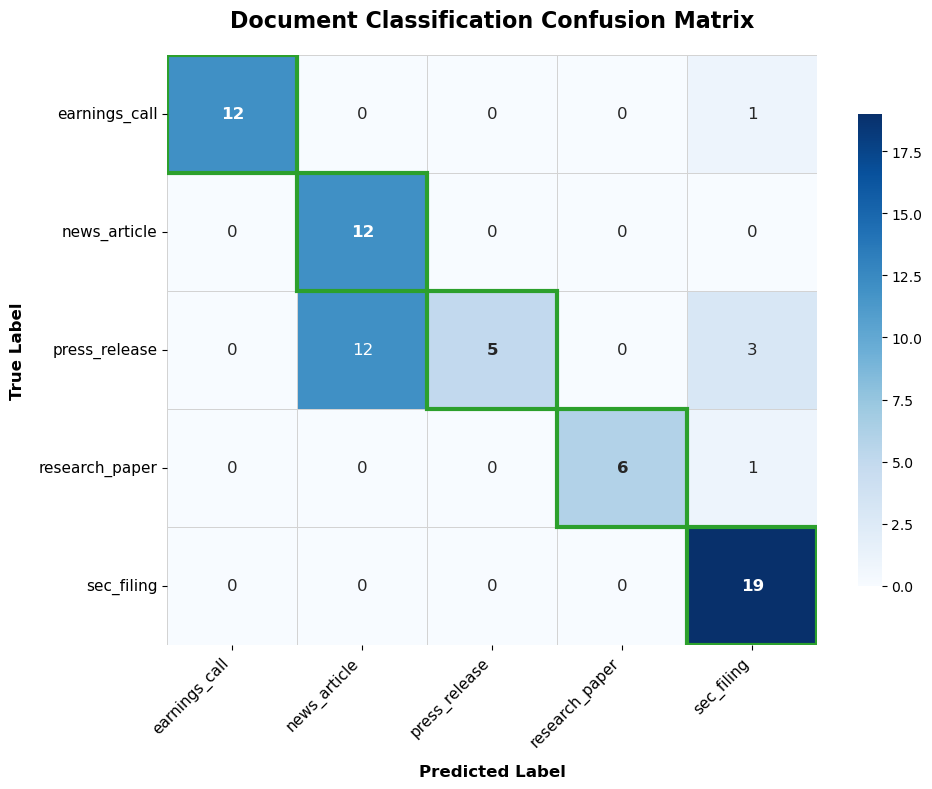

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

plt.figure(figsize=(10, 8))

ax = sns.heatmap(
    df_confusion, 
    annot=True,          
    fmt='d',             
    cmap='Blues',        
    linewidths=0.5,      
    linecolor='lightgray',
    cbar=True,           
    cbar_kws={'shrink': 0.8},
    xticklabels=df_confusion.columns, 
    yticklabels=df_confusion.index,
    annot_kws={"size": 12} 
)

for i in range(df_confusion.shape[0]):
    ax.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor='#2ca02c', lw=3))

    text_element = ax.texts[i * df_confusion.shape[1] + i]
    text_element.set_weight('bold')

plt.title('Document Classification Confusion Matrix', fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, labelpad=10, fontweight='bold')
plt.ylabel('True Label', fontsize=12, labelpad=10, fontweight='bold')

plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)

plt.tight_layout()
plt.show()

## Grouped Bar Chart of Per-Class Metrics

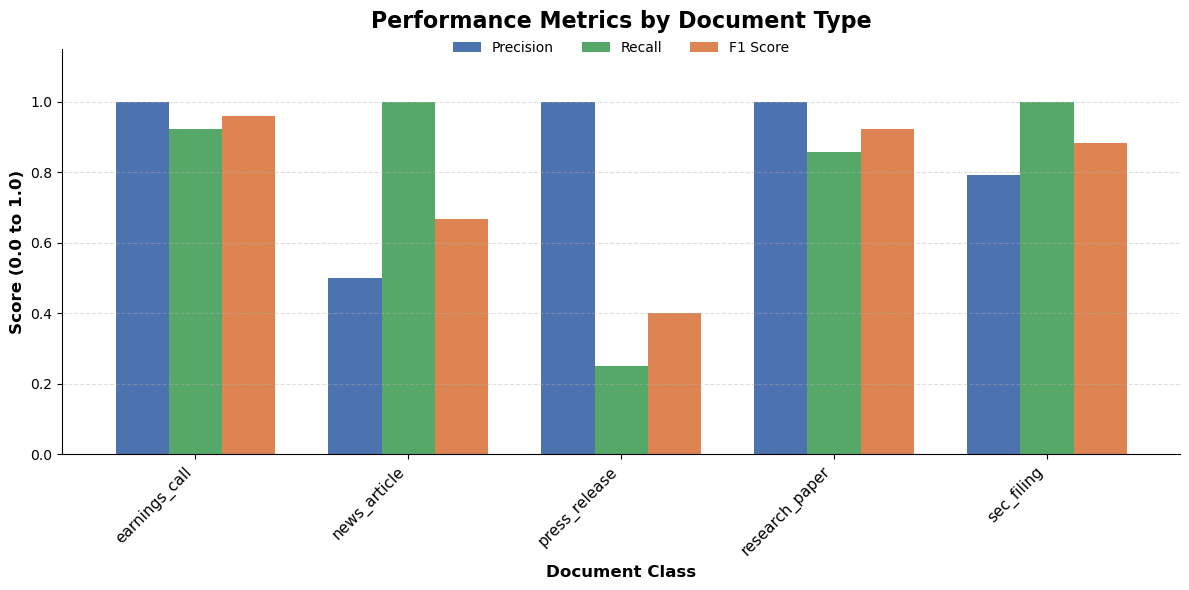

In [20]:
plot_metrics = df_metrics.drop(columns=['Support'])
custom_colors = ['#4C72B0', '#55A868', '#DD8452']

plt.figure(figsize=(12, 6))
ax = plot_metrics.plot(kind='bar', color=custom_colors, width=0.75, ax=plt.gca(), edgecolor='none')

plt.title('Performance Metrics by Document Type', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Document Class', fontsize=12, fontweight='bold')
plt.ylabel('Score (0.0 to 1.0)', fontsize=12, fontweight='bold')
plt.ylim(0, 1.15)
plt.xticks(rotation=45, ha='right', fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(['Precision', 'Recall', 'F1 Score'], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## Normalized Confusion Matrix (Percentage-Based)

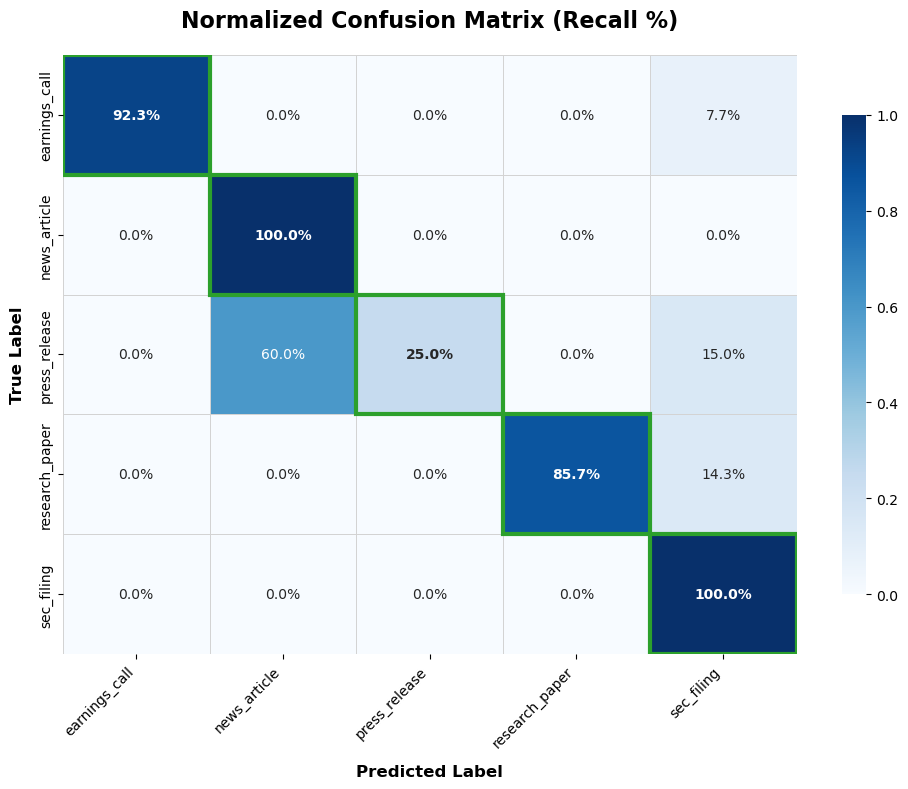

In [21]:
df_confusion_norm = df_confusion.div(df_confusion.sum(axis=1), axis=0)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    df_confusion_norm, 
    annot=True,          
    fmt='.1%',
    cmap='Blues',        
    linewidths=0.5,      
    linecolor='lightgray',
    vmin=0, vmax=1,
    cbar_kws={'shrink': 0.8},
    xticklabels=df_confusion_norm.columns, 
    yticklabels=df_confusion_norm.index
)

for i in range(df_confusion_norm.shape[0]):
    ax.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor='#2ca02c', lw=3))
    ax.texts[i * df_confusion_norm.shape[1] + i].set_weight('bold')

plt.title('Normalized Confusion Matrix (Recall %)', fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, labelpad=10, fontweight='bold')
plt.ylabel('True Label', fontsize=12, labelpad=10, fontweight='bold')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()